# README

We are seeking to evaluate the alpha method and show that as alpha changes, how this influences the frequency that a curve is evaluated as moX

# Libraries

In [20]:
#Preparing all libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import colorsys
from datetime import date
import pickle
import functools

# Initialize Parameters

In [21]:
####### Options #######
randStart = True                  #Initial guess for parameter values in random locations

In [22]:
######All Fixed parameters for code
#Parameters held constant
T11 = 600
T12 = 1200
c1 = 0.4
c2 = 0.6 
T21 = 40
T22 = 100

true_params = np.array([T11, T12, c1, c2, T21, T22])

#Building the TE array - this should be a uniform array
n_points = 64
TE_step = 8

TE_DATA = np.linspace(TE_step, TE_step*n_points, n_points) #ms units

assert(TE_DATA[-1] == 512)
d_TE = np.mean(np.diff(TE_DATA))
assert(d_TE == 8)

TI1star = np.log(2)*T11
TI2star = np.log(2)*T12


######### TI list of points used in the final evaluation
TI_DATA = np.array([0, 330, 410])#np.logspace(1,3.5,10)#np.array([0, 550, 700])#

#SNR Value to Evaluate
SNR_value = 100

alpha_array = np.arange(0.94,1.001,0.01)

#number of multistarts in the AIC filter to ensure accurate measurement
multi_starts_AIC = 3

if randStart:
    multi_starts_obj = 2
else:
    multi_starts_obj = 1

#number of iterations to evaluate consistency of AIC filter
AIC_eval_iter = 10**3

#Builds a string of parameters to use in the titles
ParamTitle_6p = [r'$T_{11}$', r'$T_{12}$', r'$c_1$', r'$c_2$', r'$T_{21}$', r'$T_{22}$']
round_Params = [round(num, 2) for num in true_params]
pList = ', '.join(str(x) for x in round_Params)
pTitleList = ', '.join(x for x in ParamTitle_6p) #Builds the list of parametes used to generate the original data

#### Important for Naming
date = date.today()
day = date.strftime('%d')
month = date.strftime('%B')[0:3]
year = date.strftime('%y')

In [23]:
#Defining the function of interest

def S_biX_6p(TE, T11, T12, c1, c2, T21, T22, TI = 0):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

#The ravel structure necessary for the curve_fit algorithm
def S_biX_6p_ravel(T_dat, T11, T12, c1, c2, T21, T22):
    TE, TI = T_dat
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

def calculate_RSS_TI(func, popt, TI_val, data):
    est_curve = func(TE_DATA, *popt, TI = TI_val)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

def S_moX_3p(TE, T1, c, T2, TI = 0):
    return c*(1-2*np.exp(-TI/T1))*np.exp(-TE/T2)

#The one dimensional models are used to evaluate if a curve is more likely monoX or biX
def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

#All curves get noise according to this equation
def add_noise(data, SNR):
    #returns a noised vector of data using the SNR given
    sigma = (c1+c2)/SNR #np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    noised_data = data + noise
    return noised_data

In [24]:
def get_func_bounds(func):
    f_name = func.__name__
    if f_name == "S_biX_6p":
        lower_bound = (2, 2, 0, 0, 2, 2)
        upper_bound = (2000, 2000, 1, 1, 150, 150)
    elif f_name == "S_moX_3p":
        lower_bound = (2, 0, 2)
        upper_bound = (2000, 1, 150)
    elif f_name == "S_biX_4p":
        lower_bound = (-1, -1, 2, 2)
        upper_bound = (1, 1, 150, 150)
    elif f_name == "S_moX_2p":
        lower_bound = (-1, 2)
        upper_bound = (1, 150)
    else:
        raise Exception("Not a valid function: " + f_name)

    return lower_bound, upper_bound

def get_param_list(func):
    f_name = func.__name__
    if f_name.find("S_biX_6p") > -1:
        params = ("T21","T22","c1","c2","T21","T22")
    elif f_name.find("S_moX_3p") > -1:
        params = ("T21","c","T2")
    else:
        raise Exception("Not a valid function: " + f_name)

    return params

def set_p0(func, random = True):
    true_params = [T11, T12, c1, c2, T21, T22]
    if random:
        lb, ub = get_func_bounds(func)
        if func.__name__.find("S_biX_6p") > -1:
            T11_est = np.random.uniform(lb[-6],ub[-6])
            T12_est = np.random.uniform(T11_est,ub[-5])
            c1_est = np.random.uniform(lb[-4],ub[-4])
            T21_est = np.random.uniform(lb[-2],ub[-2])
            T22_est = np.random.uniform(T21_est,ub[-1])
            p0 = [T11_est, T12_est, c1_est, 1-c1_est, T21_est, T22_est]
        else:
            p0 = [np.random.uniform(lb[i],ub[i]) for i in range(len(lb))]
    else:
        # f_name = func.__name__
        # if f_name.find("moX") > -1:
        #     p0 = [75, 0.5, 75]
        # elif f_name.find("biX") > -1:
        #     p0 = [75, 75, 0.5, 0.5, 75, 75]
        # else:
        p0 = true_params
            
    return p0

def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

def calculate_RSS_TI(func, popt, TI_val, data):
    est_curve = func(TE_DATA, *popt, TI = TI_val)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

def calculate_RSS(func, popt, data):
    est_curve = func(TE_DATA, *popt)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

def estP_oneCurve(func, noisey_data):

    init_p = set_p0(func, random = True)
    lb, ub = get_func_bounds(func)

    popt, _ = curve_fit(func, TE_DATA, noisey_data, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500)
    popt = check_param_order(popt)
    RSS = calculate_RSS(func, popt, noisey_data)

    return popt, RSS

In [25]:
def AIC(RSS, TE_array, p_list, sigma):

    AIC = 1/len(TE_array) * (RSS + 2*len(p_list)*(sigma)**2)

    return AIC


def evaluate_model(data, alpha, ms_iter = multi_starts_AIC):

    #Returns true if the moX is better than the biX --> returns a 1 for moX and a 0 for biX
    #Returns the parameters of the correct answer

    RSS_biX = np.inf
    RSS_moX = np.inf

    for ms in range(ms_iter):
        popt_biX_temp, RSS_biX_temp = estP_oneCurve(S_biX_4p, data)
        popt_moX_temp, RSS_moX_temp = estP_oneCurve(S_moX_2p, data)

        if RSS_biX_temp < RSS_biX:
            popt_biX = popt_biX_temp
            RSS_biX = RSS_biX_temp

        if RSS_moX_temp < RSS_moX:
            popt_moX = popt_moX_temp
            RSS_moX = RSS_moX_temp

    # popt_biX, RSS_biX = estP_oneCurve(S_biX_4p, data)
    # popt_moX, RSS_moX = estP_oneCurve(S_moX_2p, data)

    AIC_biX = AIC(RSS_biX, TE_DATA, popt_biX, 1/SNR_value)
    AIC_moX = AIC(RSS_moX, TE_DATA, popt_moX, 1/SNR_value)

    if AIC_moX < alpha*AIC_biX:
        return True, popt_moX, RSS_moX
    else:
        return False, popt_biX, RSS_biX


# Alpha Results - Frequency Analysis

In [26]:
signal_array = np.zeros([len(TI_DATA), len(TE_DATA)])

for iTI in range(len(TI_DATA)):
    signal_array[iTI,:] = S_biX_6p(TE_DATA, *true_params, TI = TI_DATA[iTI])

In [27]:
init_freq = np.zeros((len(alpha_array), len(TI_DATA)))

for iter in trange(AIC_eval_iter):

    temp_noised_data = add_noise(signal_array, SNR_value)

    for iAlp in range(len(alpha_array)):

        for iTI in range(len(TI_DATA)):
            mox_opt_iter, _, _ = evaluate_model(temp_noised_data[iTI,:], alpha_array[iAlp])
            init_freq[iAlp, iTI] += mox_opt_iter

100%|██████████| 1000/1000 [15:50<00:00,  1.05it/s]


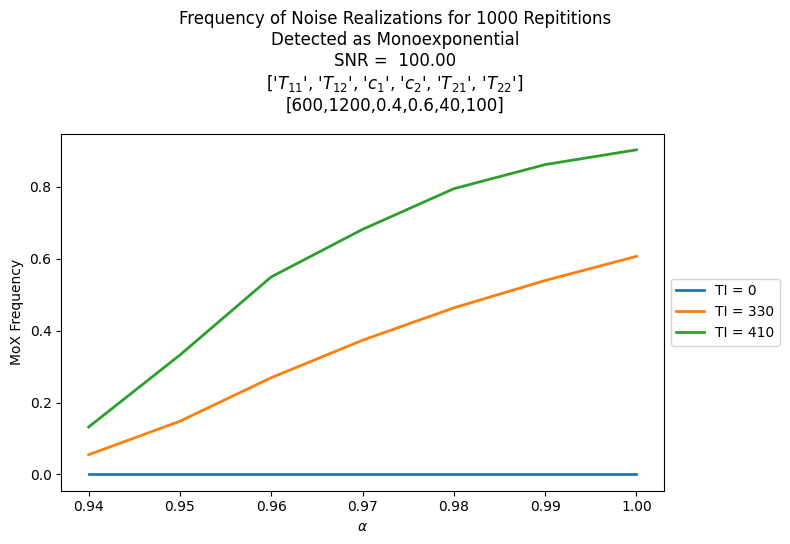

In [29]:
fig, ax = plt.subplots(1,1, figsize=(8,5.5), tight_layout=True)
fig.suptitle(f"Frequency of Noise Realizations for {AIC_eval_iter} Repititions\nDetected as Monoexponential\nSNR = {SNR_value : 0.2f}\n{ParamTitle_6p}\n[{T11},{T12},{c1},{c2},{T21},{T22}]")

for iTI in range(len(TI_DATA)):
    ax.plot(alpha_array, init_freq[:,iTI]/AIC_eval_iter, label = f'TI = {TI_DATA[iTI]}', lw = 2)


ax.set_xlabel(r'$\alpha$')
ax.set_ylabel('MoX Frequency')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))